<a href="https://colab.research.google.com/github/sayedmohamedscu/Vision-language-models-VLM/blob/main/Fine_tune_Florence_2_metere_values.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

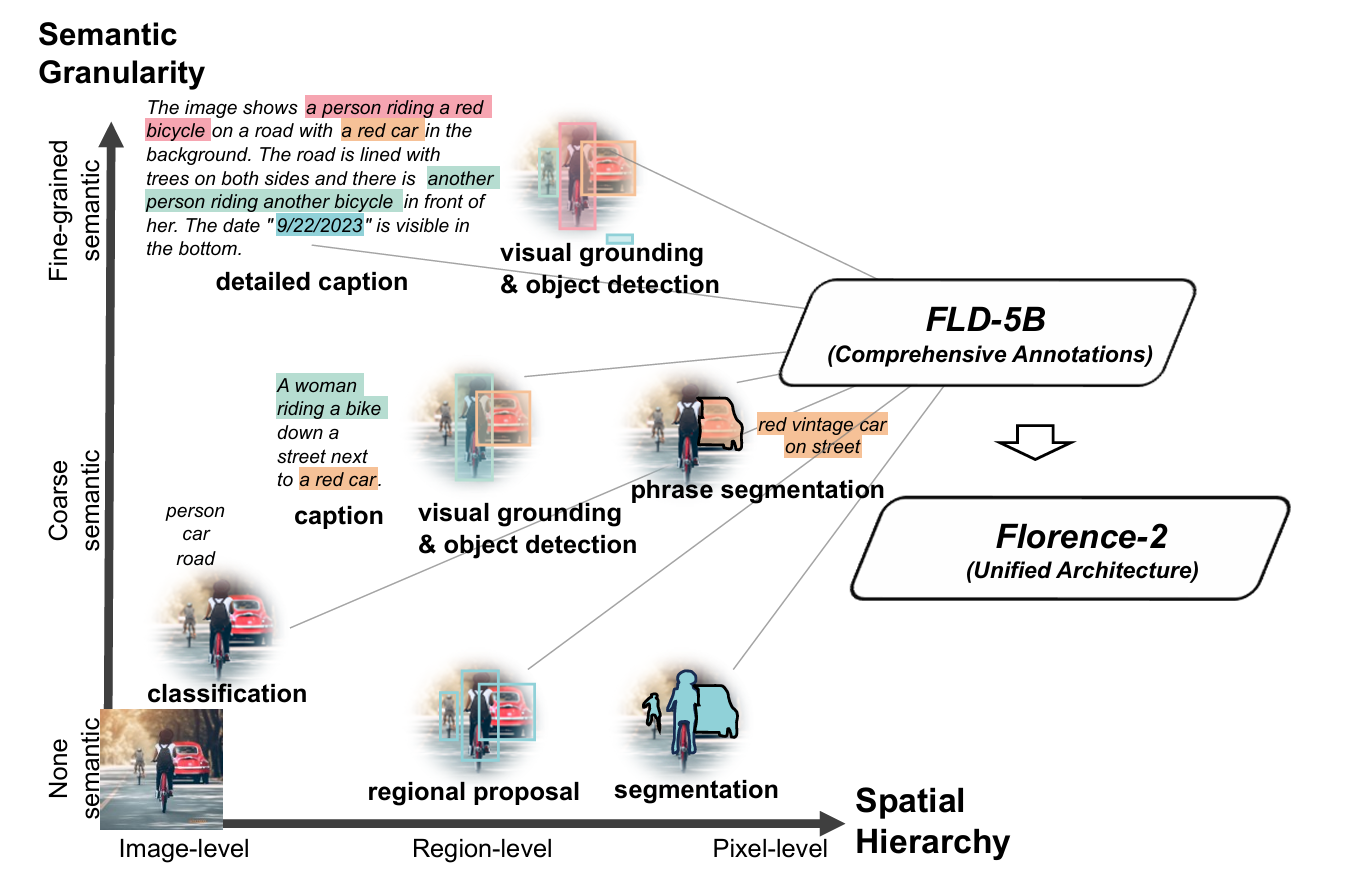

# Fine-tuning Florence-2 to read meter values

let's finetune Florence-2 to read the meter values (OCR task).

In [2]:
!pip install -q datasets flash_attn timm einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 22.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>

In [3]:
from datasets import load_dataset
ds = load_dataset('henrik-dra/energy-meter')
print(ds)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/417 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/299M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/61.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/138 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/30 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 138
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 30
    })
})


In [4]:
ds_train=ds['train']
ds_test=ds['test']


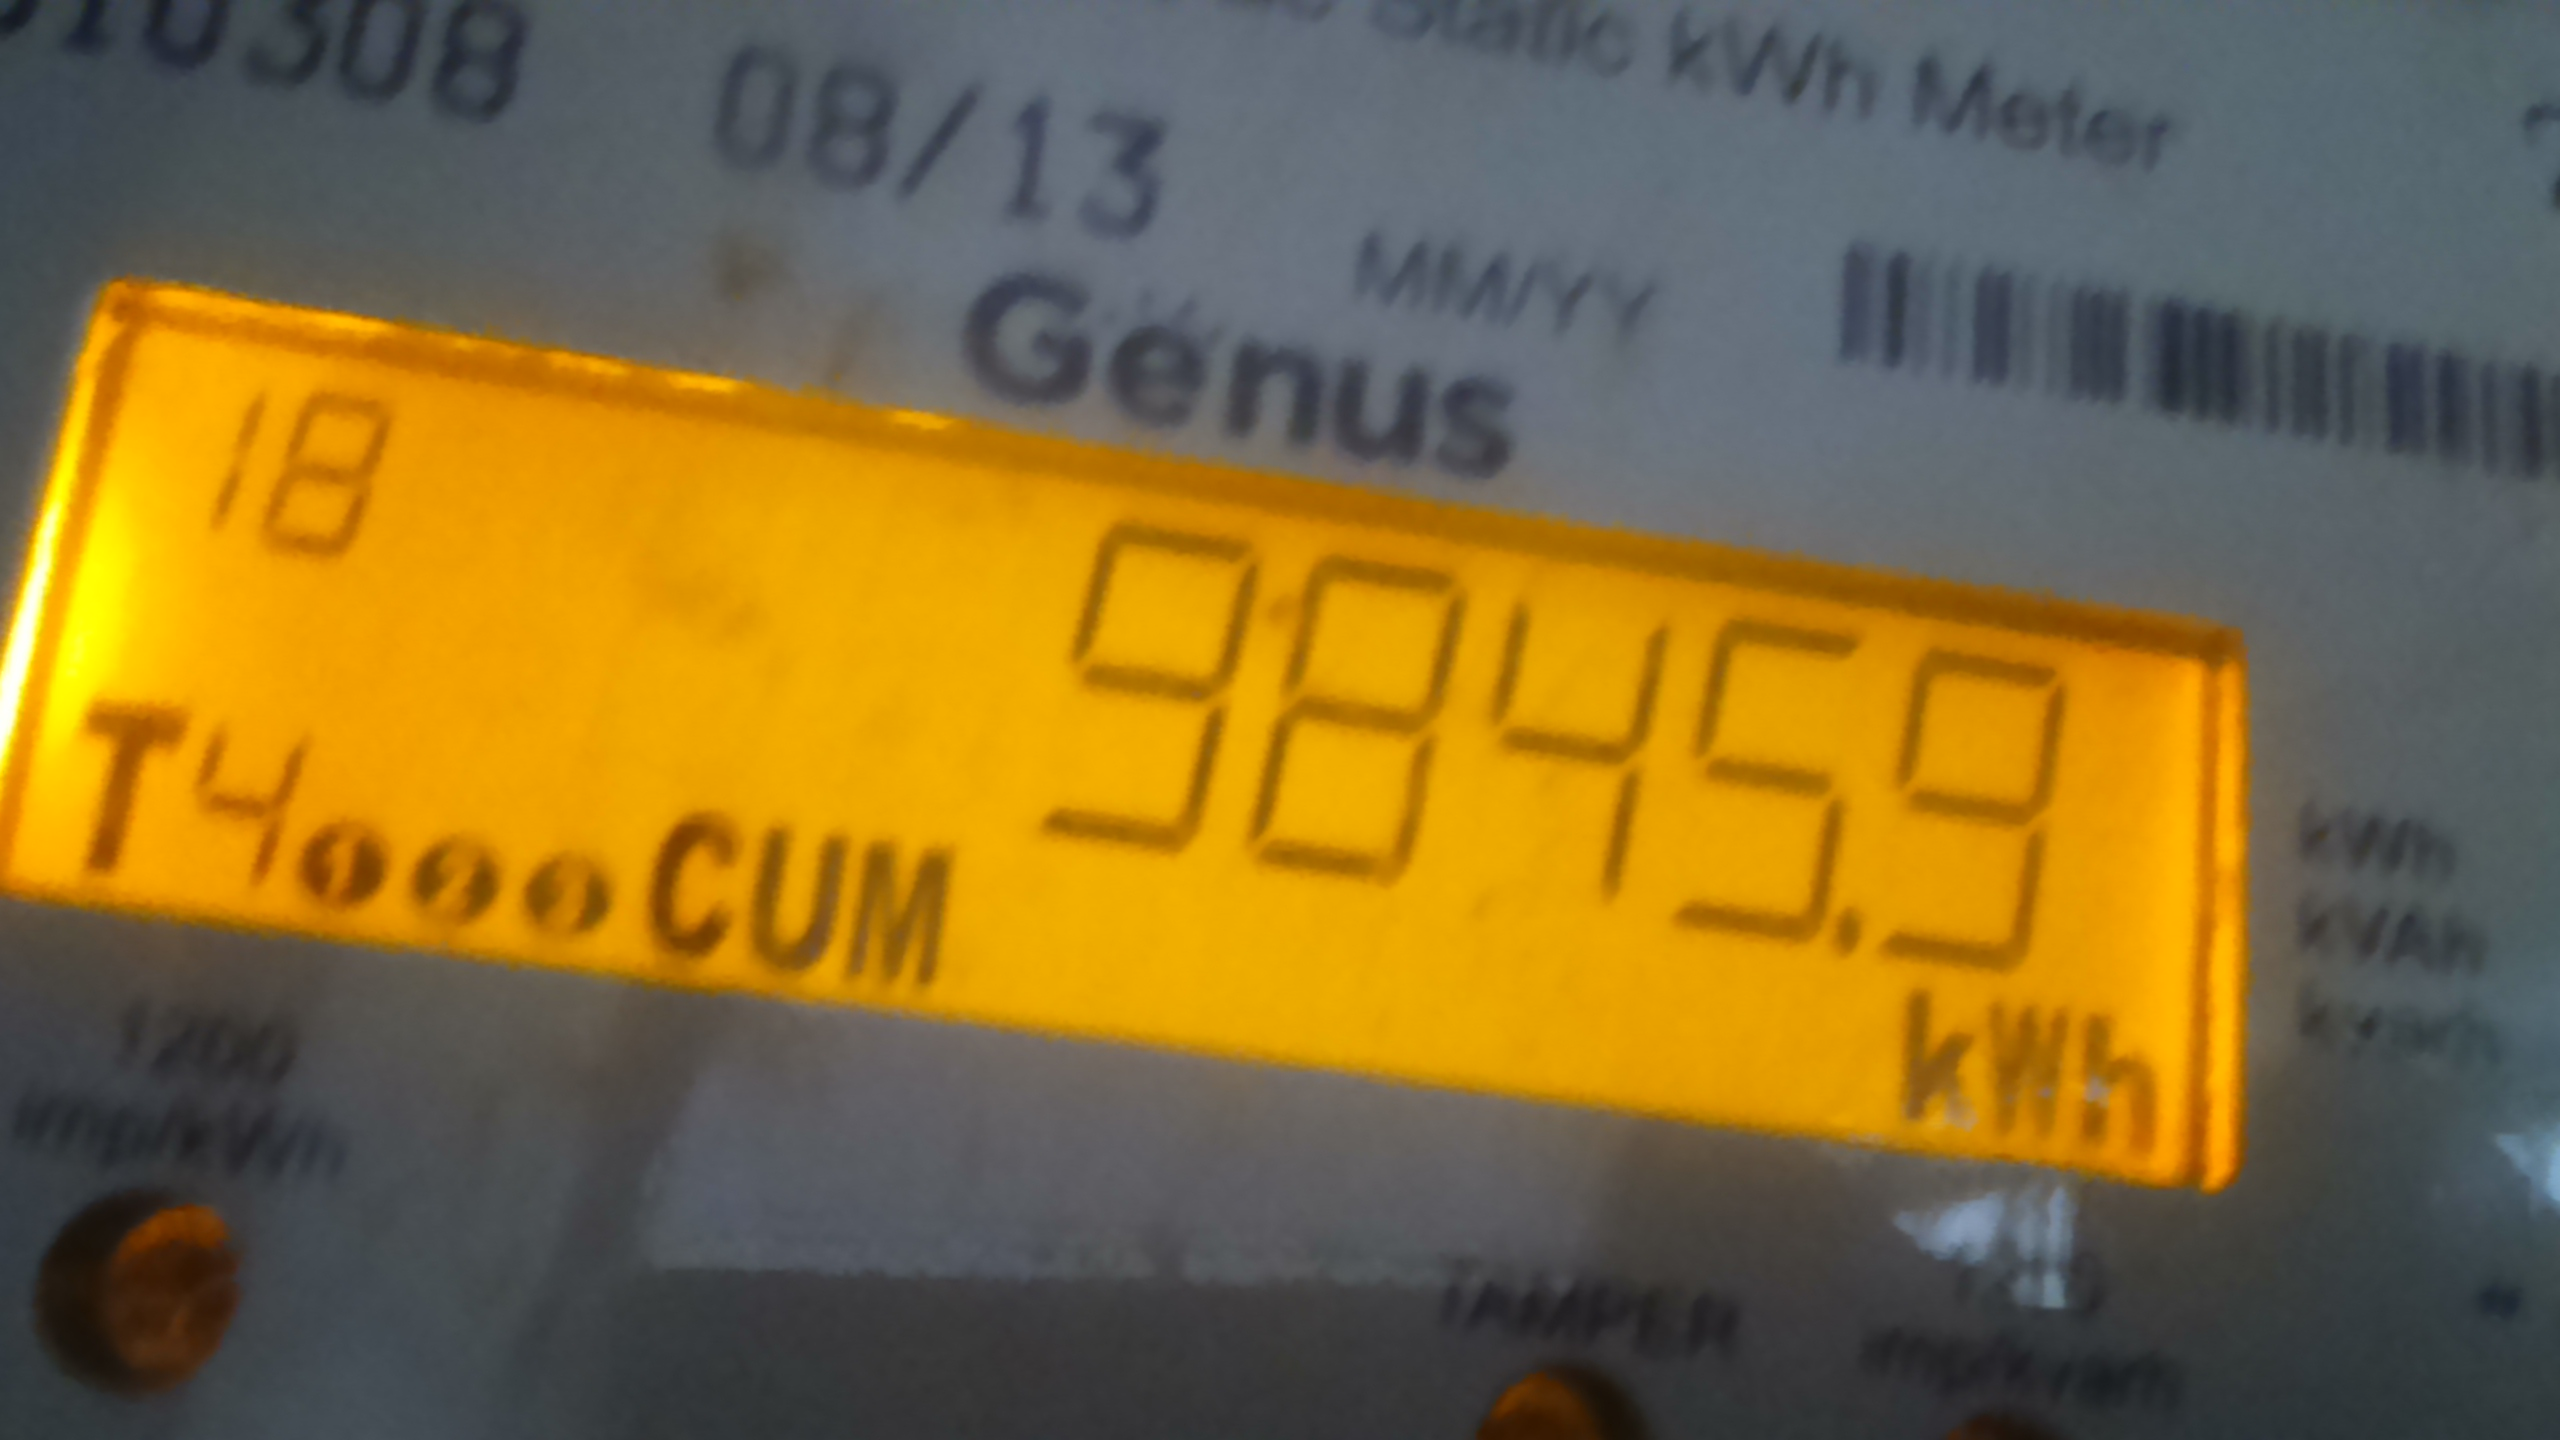

In [7]:
ds_test[0]['image']

In [8]:
ds_test[0]['label']

'9845.9'

We can load the model using `AutoModelForCausalLM` and the processor using `AutoProcessor`  classes of transformers library. Note that we need to pass `trust_remote_code` as `True` since this model is not a transformers model.

In [9]:
from transformers import AutoModelForCausalLM, AutoProcessor
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = AutoModelForCausalLM.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, revision='refs/pr/6').to(device)

processor = AutoProcessor.from_pretrained("microsoft/Florence-2-base-ft", trust_remote_code=True, revision='refs/pr/6')
torch.cuda.empty_cache()

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
# Function to run the model on an example
def run_example(task_prompt, text_input, image):
    prompt = task_prompt + text_input

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return parsed_answer


{'DocVQA': '1.92.7'}


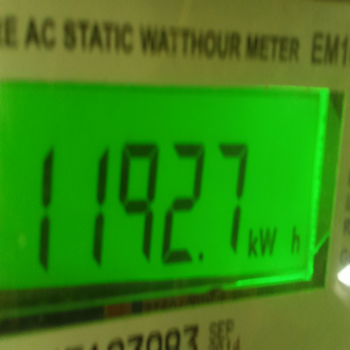

{'DocVQA': 'unanswerable'}


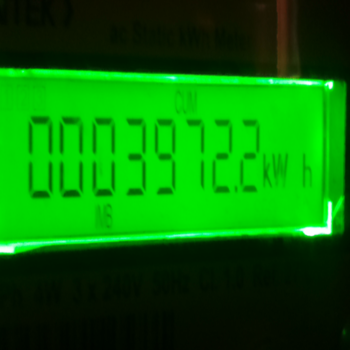

{'DocVQA': 'ok'}


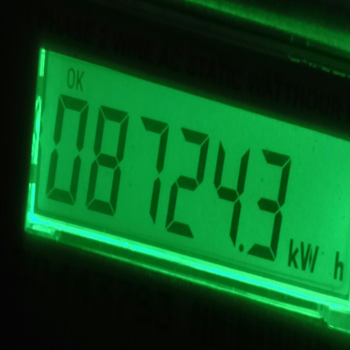

In [15]:
for idx in range(3):
  print(run_example("DocVQA", 'What is the meter values?', ds_train[idx]['image']))
  display(ds_train[idx]['image'].resize([350, 350]))

create a custo dataloader with `<DocVQA> `


In [16]:
from torch.utils.data import Dataset

class DocVQADataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question = "<DocVQA>" +'What is the meter values?'
        answer = example['label']
        image = example['image']
        if image.mode != "RGB":
            image = image.convert("RGB")
        return question, answer, image


In [27]:
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (AdamW, AutoProcessor, get_scheduler)

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(device)
    return inputs, answers

# Create datasets

train_dataset = DocVQADataset(ds_train)
val_dataset = DocVQADataset(ds_test)

# Create DataLoader
batch_size = 1
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers)

In [28]:
def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        i = -1
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            i += 1
            inputs, answers = batch

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                inputs, answers = batch

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Average Validation Loss: {avg_val_loss}")

        # Save model checkpoint
        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)


After training, we will push the model to Hugging Face Hub. To do so, we need to login first with write access. Make sure to pass either write token or fine-grained token (by first creating the repository and setting up fine-grained token access).

In [23]:
from huggingface_hub import notebook_login

notebook_login()

We will freeze image encoder for this tutorial. The authors have reported improvement in unfreezing image encoder, but note that this will result in more resource usage.

In [29]:
for param in model.vision_tower.parameters():
  param.is_trainable = False

In [30]:
train_model(train_loader, val_loader, model, processor, epochs=2)

Training Epoch 1/2: 100%|██████████| 138/138 [01:57<00:00,  1.17it/s]


Average Training Loss: 0.8210246100265911


Validation Epoch 1/2: 100%|██████████| 30/30 [00:11<00:00,  2.61it/s]


Average Validation Loss: 0.5361991782362262


Training Epoch 2/2: 100%|██████████| 138/138 [01:54<00:00,  1.20it/s]


Average Training Loss: 0.5004330876728763


Validation Epoch 2/2: 100%|██████████| 30/30 [00:11<00:00,  2.60it/s]


Average Validation Loss: 0.446567371301353


You can push the model like below. You can find the fully fine-tuned DocVQA model [here](https://huggingface.co/HuggingFaceM4/Florence-2-DocVQA). You can find the demo [here](https://huggingface.co/spaces/andito/Florence-2-DocVQA).

Read more about Florence-2 and fine-tuning it [here](https://huggingface.co/blog/finetune-florence2).

In [ ]:
model.push_to_hub("sayedM/Florence-metere")
processor.push_to_hub("sayedM/Florence-metere")

In [ ]:
model

In [31]:
# Function to run the model on an example
def run_example(task_prompt, text_input, image):
    prompt = task_prompt + text_input

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(generated_text, task=task_prompt, image_size=(image.width, image.height))
    return parsed_answer


{'DocVQA': '1192.7'}


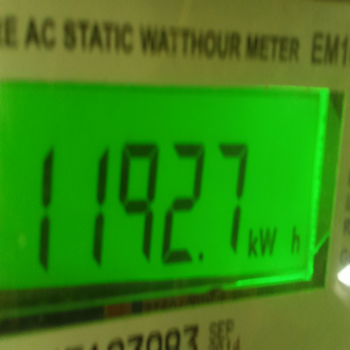

{'DocVQA': '0003972.2'}


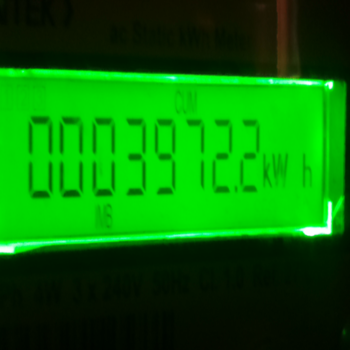

{'DocVQA': '08724.3'}


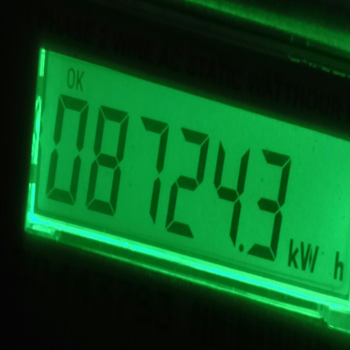

In [32]:
for idx in range(3):
  print(run_example("DocVQA", 'What is the meter values?', ds_train[idx]['image']))
  display(ds_train[idx]['image'].resize([350, 350]))

In [45]:
import requests

from PIL import Image

prompt = "<DocVQA>"+ 'What is the meter values ?'

image = Image.open("/content/electronic-meter.jpg")

inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)

generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    do_sample=False,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

parsed_answer = processor.post_process_generation(generated_text, task="<DocVQA>", image_size=(image.width, image.height))

print(parsed_answer)


{'<DocVQA>': '12345.6'}


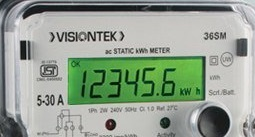

In [40]:
image